*This notebook provides a comparison of several models for water waves on the results of an experiment of
[Hammack\&Segur](https://dx.doi.org/10.1017/S002211207800020) experiment, in the spirit of [Carter](https://dx.doi.org/10.1016/j.wavemoti.2018.07.004)).*

## Initialization

Import package

In [1]:
using WaterWaves1D

Define parameters of the problem

In [2]:
d  = 0.1;  # depth of the basin (in m)
g  = 9.81; # gravitational acceleration
λ  = 0.1;  # typical horizontal length (=d to simplify)
T  = 40;   # final time (in s)
L  = 156.16;# half-length of the numerical tank (in m)  
param = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    μ  = 1,    # shallow-water dimensionless parameter
    ϵ  = 1,    # nonlinearity dimensionless parameter
    # Numerical parameters
    N  = 2^12, # number of collocation points
    L  = L/d,       # half-length of the numerical tank ( = 156.16 m)
    T  = T*sqrt(g*d)/λ, # final time of computation (= 50 s)
    dt = T*sqrt(g*d)/λ/10^3, # timestep
                )

(μ = 1, ϵ = 1, N = 4096, L = 1561.6, T = 396.18177646126026, dt = 0.39618177646126024)

Define initial data (as in [Carter](https://dx.doi.org/10.1016/j.wavemoti.2018.07.004)).


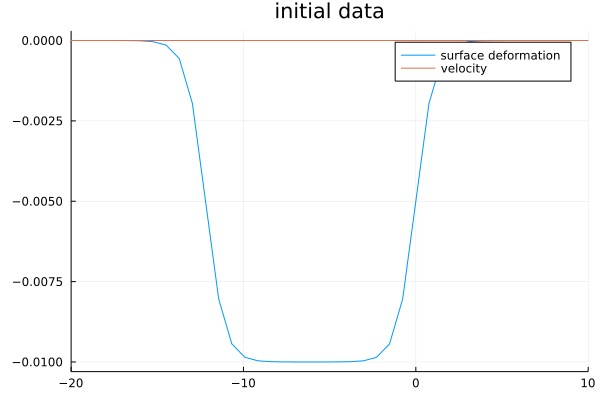

In [3]:
using Elliptic,Plots
a = 0.005 # half-amplitude of the initial data (in m)
sn(x) = getindex.(ellipj.(9.25434*x*d,0.9999^2),1);  # regularized step function
η0(x) = (-1/2*a.+1/2*a*sn(x)).*(x*d.<.61).*(x*d.>-1.83)/d;
init = Init(x->2*η0(x),x->zero(x));         # generate the initial data with correct type

x=Mesh(param).x
plot(x,[init.η(x)*d init.v(x)],
    title="initial data",
    label=["surface deformation" "velocity"],
    xlims=(-20,10)
    )

Set up initial-value problems for different models to compare

In [4]:
model_WW2=WWn(param;n=2,dealias=1,δ=1/10) # The quadratic water waves model (WW2)
model_SGN=SerreGreenNaghdi(param) # The Serre-Green-Naghdi model (SGN)
model_WGN=WhithamGreenNaghdi(param) # The fully dispersive Whitham-Green-Naghdi model (WGN)
# type `?WaterWaves` or `?WWn`, etc. to see details and signification of arguments
WW2=Problem(model_WW2, init, param) ;
SGN=Problem(model_SGN, init, param) ;
WGN=Problem(model_WGN, init, param) ;

## Computation

Solve integration in time

In [5]:
solve!(WW2);solve!(SGN);solve!(WGN);

┌ Info: Now solving the initial-value problem WW2
│ with timestep dt=0.39618177646126024, final time T=396.18177646126026,
│ and N=4096 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Now solving the initial-value problem Green-Naghdi
│ with timestep dt=0.39618177646126024, final time T=396.18177646126026,
│ and N=4096 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
┌ Info: Now solving the initial-value problem Whitham-Green-Naghdi
│ with timestep dt=0.39618177646126024, final time T=396.18177646126026,
│ and N=4096 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


## Visualization

Import the data (from the [Hammack\&Segur](https://dx.doi.org/10.1017/S0022112078000208) experiment, kindly provided by [Carter](https://dx.doi.org/10.1016/j.wavemoti.2018.07.004))

In [6]:
using DelimitedFiles
data2a = readdlm("./Hammack-Segur/Fig2aFixed.out",'\t');
data2b = readdlm("./Hammack-Segur/Fig2bFixed.out",'\t');
data2c = readdlm("./Hammack-Segur/Fig2cFixed.out",'\t');
data2d = readdlm("./Hammack-Segur/Fig2dFixed.out",'\t');
data2e = readdlm("./Hammack-Segur/Fig2eFixed.out",'\t');

In [7]:
""" 
    gauge(p::Problem;x,t)

Give the surface elevation provided by a problem 
at a specific location `x` (by default, `x=0`), 
and at times defined by `t` if provided (otherwise at all computed times).
"""
function gauge(p::Problem;x=0,T=nothing)
    if T==nothing
        times=p.times.ts
    elseif T[1]==T
        times=[T]
    else
        times=T
    end
    times/sqrt(g*d)*λ,[solution(p,T=ti,x=[x])[1][1] for ti in times]*d
end
nothing

Plot data and numerics at first gauge

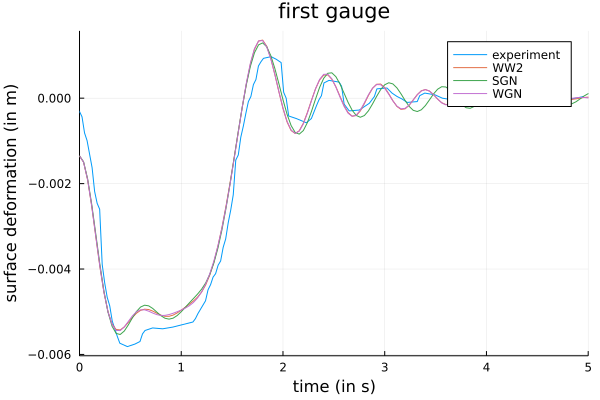

In [8]:
plt=plot(data2a[:,1]/sqrt(g*d)*λ,data2a[:,2]*d*2/3,
    title="first gauge",
    label="experiment",
    xlabel="time (in s)",
    ylabel="surface deformation (in m)")
plot!([gauge(WW2,x=1),gauge(SGN,x=1),gauge(WGN,x=1)],
    label=["WW2" "SGN" "WGN"])
xlims!(0,5)

Plot data and numerics at second gauge

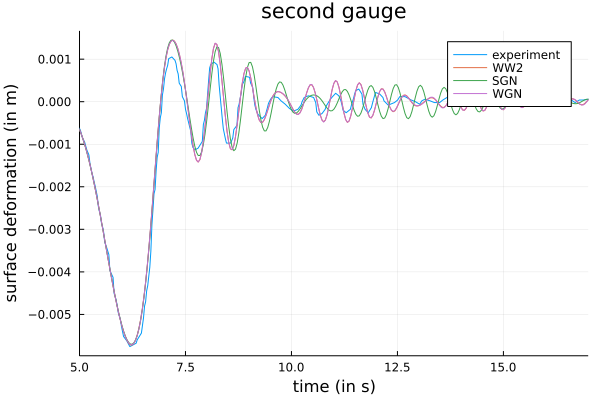

In [9]:
plt=plot((data2b[:,1].+50)/sqrt(g*d)*λ,data2b[:,2]*d*2/3,
    title="second gauge",
    label="experiment",
    xlabel="time (in s)",
    ylabel="surface deformation (in m)")
plot!([gauge(WW2,x=51),gauge(SGN,x=51),gauge(WGN,x=51)],
    label=["WW2" "SGN" "WGN"])
xlims!(5,17)

Plot data and numerics at third gauge

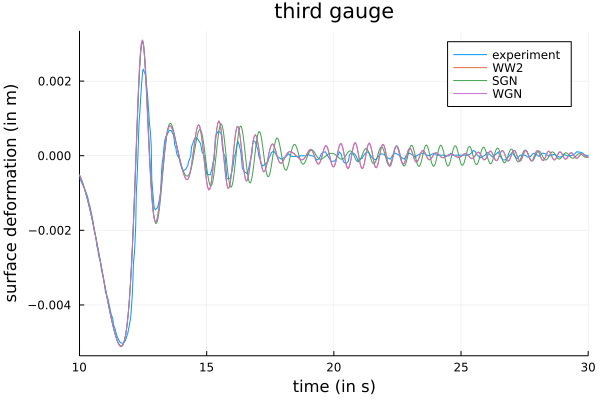

In [10]:
plt=plot((data2c[:,1].+100)/sqrt(g*d)*λ,data2c[:,2]*d*2/3,
    title="third gauge",
    label="experiment",
    xlabel="time (in s)",
    ylabel="surface deformation (in m)")
plot!([gauge(WW2,x=101),gauge(SGN,x=101),gauge(WGN,x=101)],
    label=["WW2" "SGN" "WGN"])
xlims!(10,30)

Plot data and numerics at fourth gauge

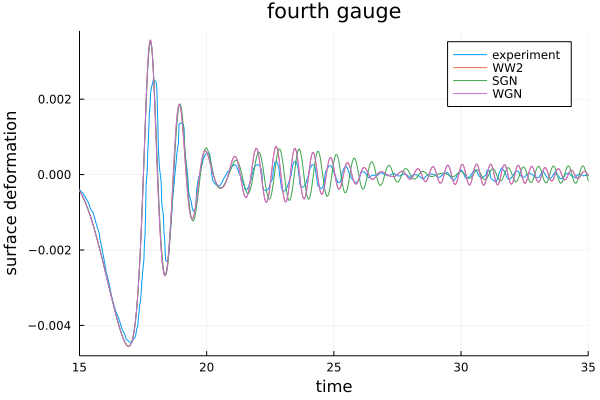

In [11]:
plt=plot((data2d[:,1].+150)/sqrt(g*d)*λ,data2d[:,2]*d*2/3,
    title="fourth gauge",
    label="experiment",
    xlabel="time",
    ylabel="surface deformation")
plot!([gauge(WW2,x=151),gauge(SGN,x=151),gauge(WGN,x=151)],
    label=["WW2" "SGN" "WGN"])
xlims!(15,35)

Plot data and numerics at fifth gauge

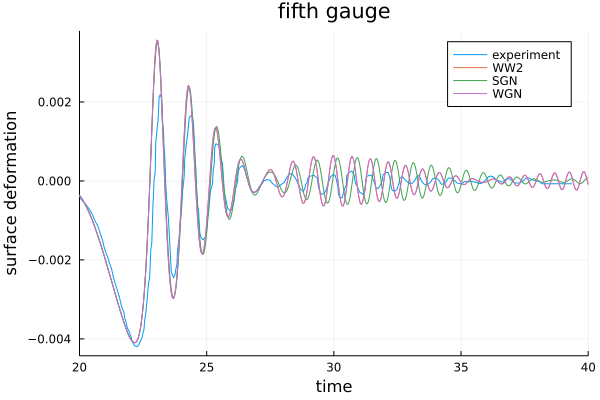

In [12]:
plt=plot((data2e[:,1].+200)/sqrt(g*d)*λ,data2e[:,2]*d*2/3,
    title="fifth gauge",
    label="experiment",
    xlabel="time",
    ylabel="surface deformation")
plot!([gauge(WW2,x=201),gauge(SGN,x=201),gauge(WGN,x=201)],
    label=["WW2" "SGN" "WGN"])
xlims!(20,40)

The quadratic water waves model and Whitham-Green-Naghdi model predict are almost indistinguishable, because the *steepness* of the wave is very small.